In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


ICE CREAM DATA

In [ ]:
def Parser(s):
  return datetime.strptime(s, "%Y-%m-%d")


In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path = "/content/drive/My Drive/ice_cream.csv"

In [ ]:
df_ice_cream = pd.read_csv(Path, parse_dates=[0], index_col=0, squeeze=True, date_parser= Parser)

In [ ]:
df_ice_cream.rename('Production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: Production, Length: 577, dtype: float64

In [ ]:
df_ice_cream = df_ice_cream.asfreq(pd.infer_freq(df_ice_cream.index))

In [ ]:
start_date = pd.to_datetime('2010-01-01')

In [ ]:
df_ice_cream = df_ice_cream[start_date:]

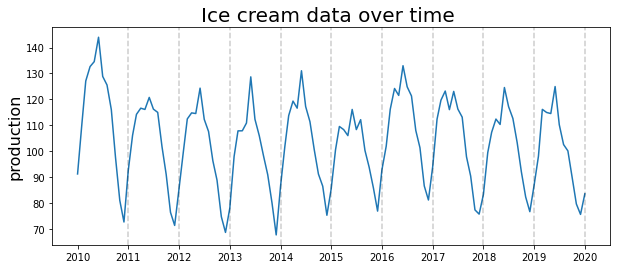

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_ice_cream)
plt.title("Ice cream data over time ", fontsize = 20)
plt.ylabel("production" , fontsize = 16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha = 0.2)

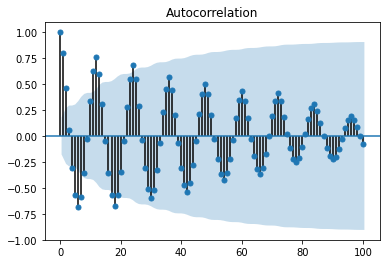

In [ ]:
acf_plot = plot_acf(df_ice_cream, lags = 100)

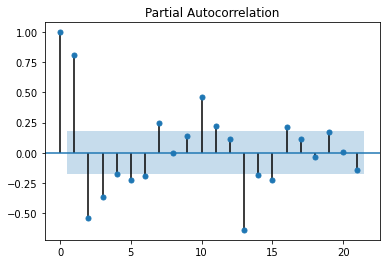

In [ ]:
pacf_plot = plot_pacf(df_ice_cream)

**Train and Test Data**

In [ ]:
train_end = datetime(2016, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = df_ice_cream[:train_end]
test_data = df_ice_cream[train_end + timedelta(days=1) : test_end]

**Fit ARMA Model**

In [ ]:
model = ARMA(train_data, order = (3,0))

In [ ]:
start = time()
model_fit = model.fit()
end = time()
print(f" Model training time {end - start}")

 Model training time 0.08049392700195312


In [ ]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             Production   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Sun, 07 Nov 2021   AIC                            598.015
Time:                        14:52:47   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.Production     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.Production    -0.0532 

**Get Predictions**

In [ ]:
pred_start_date = test_data.index[0] 
pred_end_date = test_data.index[-1]

In [ ]:
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data - predictions

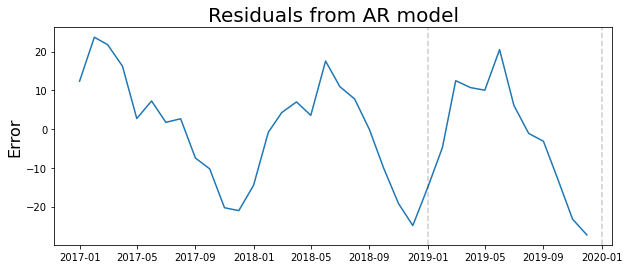

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals from AR model", fontsize = 20)
plt.ylabel("Error" , fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha = 0.2)

**Plot Predictions over time**

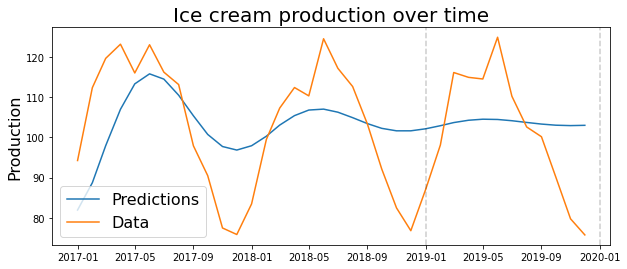

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(predictions)
plt.plot(test_data)
plt.legend(('Predictions','Data'), fontsize=16)
plt.title("Ice cream production over time", fontsize = 20)
plt.ylabel("Production" , fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha = 0.2)

In [ ]:
# Mean absolute error
print( f"Mean absolute Error {round(np.mean(abs(residuals/test_data)), 4)}")

Mean absolute Error 0.1211


In [ ]:
# Root Mean squared error
print( f"Root Mean squared Error {np.sqrt(np.mean(residuals**2))}")

Root Mean squared Error 13.889857634216284


**ROLLING FORECAST Origin**

Idea : Always predict one month in advance

Train on months 1,2,3,........ k-3 => predict for month k-2
Train on months 1,2,3,.........k-3, k-2 => predict for month k-1
Train on months 1,2,3,.........k-3, k-2, k-1 => predict for month k

...

Average all predictions



In [ ]:
# create the model
predictions_rolling = pd.Series()
for end_date in test_data.index:
  train_data = df_ice_cream[:end_date - timedelta(days=1)]
  model = ARMA(train_data, order = (3,0))
  model_fit = model.fit()
  pred = model_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred.loc[end_date]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
residuals_rolling = test_data - predictions_rolling 

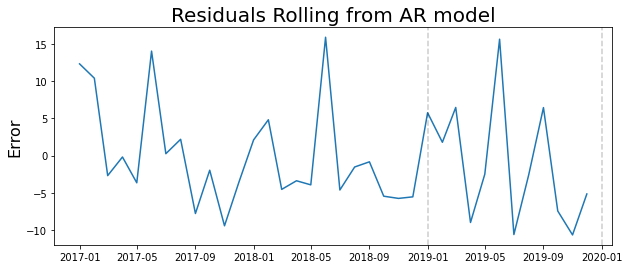

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title("Residuals Rolling from AR model", fontsize = 20)
plt.ylabel("Error" , fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha = 0.2)

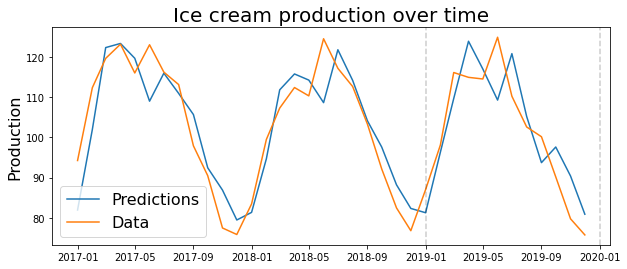

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(predictions_rolling)
plt.plot(test_data)
plt.legend(('Predictions','Data'), fontsize=16)
plt.title("Ice cream production over time", fontsize = 20)
plt.ylabel("Production" , fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha = 0.2)